<a href="https://colab.research.google.com/github/gabrielcerono/GlioblastomaMultiforme/blob/main/Lammer2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The paper is found here: https://doi.org/10.1371/journal.pone.0221502https://doi.org/10.1371/journal.pone.0221502


The original dataset here: https://figshare.com/articles/dataset/Clinical_data_of_individual_patients_/14201600

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [50]:
dataset = pd.read_csv('/content/glioblastomadataset.csv')

In [51]:
dataset.head()

sex_0f_1m  age_years  did_progress  ...  cHsp70_0low_1high  survival  PFS_months
0          0         50             1  ...                  0         0         4.6
1          0         60             1  ...                  0         0         0.7
2          0         53             1  ...                  0         1        11.3
3          0         43             1  ...                  0         1        10.3
4          0         65             1  ...                  0         0         7.9

[5 rows x 7 columns]

In [52]:
dataset.describe()

sex_0f_1m  age_years  ...   survival  PFS_months
count  60.000000  60.000000  ...  60.000000   60.000000
mean    0.583333  56.983333  ...   0.400000   15.713333
std     0.497167  12.085138  ...   0.494032   11.745962
min     0.000000  20.000000  ...   0.000000    0.700000
25%     0.000000  50.750000  ...   0.000000    8.925000
50%     1.000000  58.000000  ...   0.000000   12.500000
75%     1.000000  65.250000  ...   1.000000   21.300000
max     1.000000  78.000000  ...   1.000000   52.400000

[8 rows x 7 columns]

# First, we should make a quick data exploratory analysis.

In [53]:
import seaborn as sns

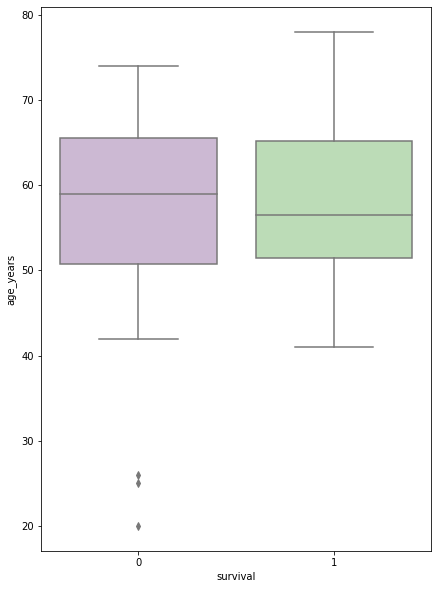

In [54]:
f,ax = plt.subplots(figsize =(7,10))
sns.boxplot(x="survival", y = 'age_years', data=dataset, palette="PRGn",ax=ax)
plt.show()

(0.0, 1.0)

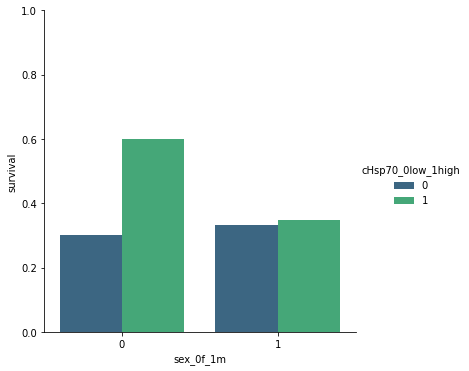

In [55]:
sns.catplot(x="sex_0f_1m", y="survival", hue="cHsp70_0low_1high", ci=None, palette='viridis', kind="bar", data=dataset)
plt.ylim(0, 1)

It seems that high levels cHsp70 increase survival rate only in females, something the original paper did not mention. We would have to look for covariates, and see if sex actually impact un survivality.

(0.0, 1.0)

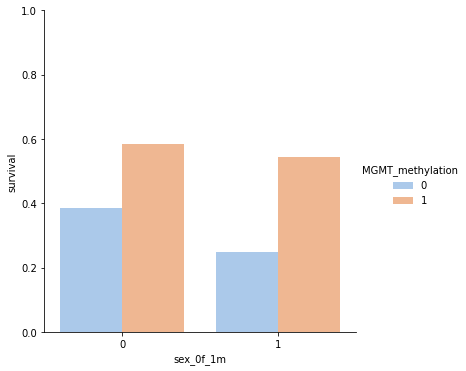

In [56]:
sns.catplot(x="sex_0f_1m", y="survival", hue="MGMT_methylation", kind="bar", palette="pastel", ci=None, data=dataset)
plt.ylim(0, 1)

(0.0, 1.0)

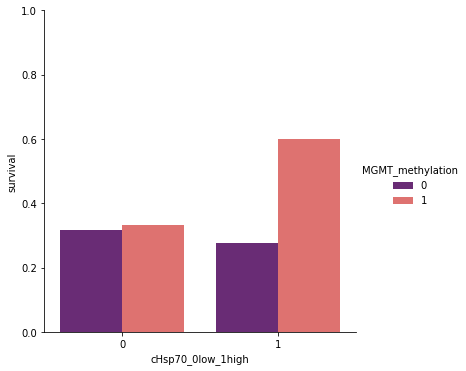

In [57]:
sns.catplot(x="cHsp70_0low_1high", y="survival", hue="MGMT_methylation", kind="bar", ci=None,  palette="magma", data=dataset)
plt.ylim(0, 1)

It seems like MGMT methylation has a permissive effect on ChSp. The original paper did arrived to this conclusion. 

(0.0, 1.2)

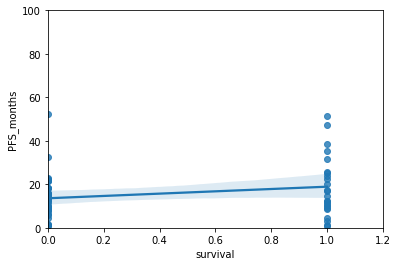

In [58]:
sns.regplot(x="survival", y="PFS_months", data=dataset)
plt.ylim(0, 100)
plt.xlim(0, 1.2)

In [59]:
dataset.corr(method='pearson')

sex_0f_1m  age_years  ...  survival  PFS_months
sex_0f_1m           1.000000  -0.269165  ... -0.138013    0.039569
age_years          -0.269165   1.000000  ...  0.080623    0.177742
did_progress       -0.010193  -0.161440  ... -0.369274   -0.456801
MGMT_methylation   -0.168035   0.118375  ...  0.265897    0.320183
cHsp70_0low_1high   0.058461   0.079750  ...  0.127076    0.328388
survival           -0.138013   0.080623  ...  1.000000    0.223676
PFS_months          0.039569   0.177742  ...  0.223676    1.000000

[7 rows x 7 columns]

# First Analysis


First we want to divide the dataset in 3 sections:

1.   Train set
2.   Ranking feature set
3.   Test



In [60]:
X = dataset.drop(columns=['survival', 'PFS_months'], axis = 1)
y = dataset['survival']

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef

In [63]:
clf = RandomForestClassifier(random_state=0)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [65]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [66]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [67]:
f1_score(y_test, clf.predict(X_test))

0.3529411764705882

In [68]:
confusion_matrix(y_test, clf.predict(X_test))

array([[6, 3],
       [8, 3]])

## RFE with Matthew score as ranking system - Without Pogression free time 

In [69]:
import RFE_Glioblastoma as rfe

In [70]:
ranking = rfe.RankingRE(X, y, 100, clf)

In [71]:
rank, metrics = ranking.ranking_by_matthew_punishment()

In [72]:
rank

Categories average-mtt-punishment  ranking SD_of_matt_punishment
2       did_progress    0.06372320627966749      1.0    0.1555332751945295
3   MGMT_methylation    0.01748624818666679      2.0    0.2023388183350212
0          sex_0f_1m   0.012046948828525517      3.0   0.18397869782161339
1          age_years   -0.11287338559647032      4.0    0.2590059656570587
4  cHsp70_0low_1high  -0.019071429118095954      5.0   0.15960884297058184

In [73]:
metrics

matthewscore  f1-score  Accuracy  ...  True Negatives   ROC AUC    PR AUC
0      0.118034  0.396463    0.5805  ...         0.70366  0.556744  0.493785

[1 rows x 7 columns]

## [XgBoost]

In [74]:
import xgboost as xgb


In [75]:
xgb_model = xgb.XGBClassifier(random_state=42)

In [76]:
ranking_xgb = rfe.RankingRE(X, y, 100, xgb_model)

In [77]:
rank_xgb, metrics_xgb = ranking_xgb.ranking_by_matthew_punishment()

In [78]:
rank_xgb

Categories average-mtt-punishment  ranking SD_of_matt_punishment
3   MGMT_methylation   0.024558382406383094      1.0   0.16119283812669075
2       did_progress  0.0006546540440286216      2.0  0.006513725494595207
1          age_years   -0.09136617246844875      3.0   0.22589242931684492
0          sex_0f_1m  -0.015332535877537311      4.0   0.15621016087089828
4  cHsp70_0low_1high  -0.009570804858977149      5.0    0.1284199119523707

In [79]:
 metrics_xgb 

matthewscore  f1-score  Accuracy  ...  True Negatives   ROC AUC    PR AUC
0     -0.008832  0.321847    0.5165  ...        0.650153  0.506469  0.447482

[1 rows x 7 columns]

## Logistic Regression


In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
log_regressor = LogisticRegression(random_state=42)

In [82]:
ranking_lgr = rfe.RankingRE(X, y, 100, log_regressor)

In [83]:
rank_lgr, metrics_lgr = ranking_lgr.ranking_by_matthew_punishment()

In [84]:
rank_lgr

Categories average-mtt-punishment  ranking SD_of_matt_punishment
2       did_progress    0.06402542313015255      1.0   0.13948621865752894
3   MGMT_methylation    0.04763654067297669      2.0   0.16548833014266537
1          age_years  -0.061350892408696824      3.0      0.18870687229184
0          sex_0f_1m   -0.02843423006622815      4.0   0.14966363033301205
4  cHsp70_0low_1high   -0.01176847552435224      5.0   0.12921303240488743

In [85]:
metrics_lgr

matthewscore  f1-score  Accuracy  ...  True Negatives   ROC AUC    PR AUC
0      0.095865  0.306615     0.562  ...        0.773156  0.556414  0.512744

[1 rows x 7 columns]

## Decision Trees

In [86]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier(random_state=42)

In [87]:
ranking_dct = rfe.RankingRE(X, y, 100, dec_tree)

In [88]:
rank_dct, metrics_dct = ranking_dct.ranking_by_matthew_punishment()

In [89]:
rank_dct

Categories average-mtt-punishment  ranking SD_of_matt_punishment
2       did_progress    0.06855658735393043      1.0    0.1630860253163553
3   MGMT_methylation   0.005724624767096042      2.0   0.17928571437479818
1          age_years   -0.12427462582713263      3.0   0.26760754158297034
4  cHsp70_0low_1high   -0.01733317585580805      4.0   0.11437788833268668
0          sex_0f_1m  -0.004187514235910624      5.0   0.11356166255095122

In [90]:
metrics_dct

matthewscore  f1-score  Accuracy  ...  True Negatives   ROC AUC    PR AUC
0      0.028971  0.404486    0.5185  ...        0.583787  0.517166  0.551611

[1 rows x 7 columns]

## K-Nearest Neightbors

In [91]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [92]:
ranking_knn = rfe.RankingRE(X, y, 100, knn)

In [93]:
rank_knn, metrics_knn = ranking_knn.ranking_by_matthew_punishment()

In [94]:
rank_knn

Categories average-mtt-punishment  ranking SD_of_matt_punishment
2       did_progress   0.004683616483192665      1.0  0.044126478443801305
3   MGMT_methylation  0.0038386279957425573      2.0  0.047091790625171874
1          age_years   -0.14730433180517744      3.0    0.3071626478540861
0          sex_0f_1m  -0.010051504658167646      4.0   0.07205418778046549
4  cHsp70_0low_1high  -0.004283943007981022      5.0   0.06754610842745187

In [95]:
metrics_knn

matthewscore  f1-score  Accuracy  ...  True Negatives  ROC AUC    PR AUC
0     -0.023987  0.254812     0.536  ...        0.714223   0.4953  0.466794

[1 rows x 7 columns]